# Autonomous driving - Car detection



In [30]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

## 1 - Problem Statement

We are working on a self-driving car. As a critical component of this project, we'd like to first build a car detection system. To collect data, we are supposed to  mount a camera to the hood (meaning the front) of the car, which takes pictures of the road ahead every few seconds while we drive around. 

But, we used drive.ai dataset

If we have 80 classes that we want YOLO to recognize, we can represent the class label  either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1 and the rest of which are 0. 

## 2 - YOLO

YOLO ("you only look once") is a popular algoritm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### 2.1 - Model details

First things to know:
- The **input** is a batch of images of shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

We will use 5 anchor boxes. So you can think of the YOLO architecture as the following: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).

Lets look in greater detail at what this encoding represents. 



If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).



Now, for each box (of each cell) we will compute the following elementwise product and extract a probability that the box contains a certain class.



Here's one way to visualize what YOLO is predicting on an image:
- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across both the 5 anchor boxes and across different classes). 
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 



Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm. 


Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  



In the figure above, we plotted only boxes that the model had assigned a high probability to, but this is still too many boxes. You'd like to filter the algorithm's output down to a much smaller number of detected objects. To do so, you'll use non-max suppression. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class)
- Select only one box when several boxes overlap with each other and detect the same object.



### 2.2 - Filtering with a threshold on class scores

We are going to apply a first filter by thresholding. You would like to get rid of any box for which the class "score" is less than a chosen threshold. 

The model gives you a total of 19x19x5x85 numbers, with each box described by 85 numbers. It'll be convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:  
- `box_confidence`: tensor of shape $(19 \times 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19 \times 19, 5, 4)$ containing $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes per cell.
- `box_class_probs`: tensor of shape $(19 \times 19, 5, 80)$ containing the detection probabilities $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.

**Exercise**: Implement `yolo_filter_boxes()`.
1. Compute box scores by doing the elementwise product as described in Figure 4. The following code may help you choose the right operator: 
```python
a = np.random.randn(19*19, 5, 1)
b = np.random.randn(19*19, 5, 80)
c = a * b # shape of c will be (19*19, 5, 80)
```
2. For each box, find:
    - the index of the class with the maximum box score ([Hint](https://keras.io/backend/#argmax)) (Be careful with what axis you choose; consider using axis=-1)
    - the corresponding box score ([Hint](https://keras.io/backend/#max)) (Be careful with what axis you choose; consider using axis=-1)
3. Create a mask by using a threshold. As a reminder: `([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4)` returns: `[False, True, False, False, True]`. The mask should be True for the boxes you want to keep. 
4. Use TensorFlow to apply the mask to box_class_scores, boxes and box_classes to filter out the boxes we don't want. You should be left with just the subset of boxes you want to keep. ([Hint](https://www.tensorflow.org/api_docs/python/tf/boolean_mask))



In [1]:
# GRADED FUNCTION: yolo_filter_boxes

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    box_scores = np.multiply(box_confidence,box_class_probs)
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    box_classes =K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = K.greater_equal(box_class_scores, threshold)

    
    # Step 4: Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    
    return scores, boxes, classes

In [3]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

scores[2] = 10.7506
boxes[2] = [ 8.42653275  3.27136683 -0.5313437  -4.94137383]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


### 2.3 - Non-max suppression ###

Even after filtering by thresholding over the classes scores, you still end up a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

In [2]:
# GRADED FUNCTION: iou

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = np.maximum(box1[0], box2[0])
    yi1 = np.maximum(box1[1], box2[1])
    xi2 = np.minimum(box1[2], box2[2])
    yi2 = np.minimum(box1[3], box2[3])
    inter_area = np.maximum((xi2 - xi1),0)*np.maximum((yi2 - yi1),0)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[3] - box1[1])*(box1[2]- box1[0])
    box2_area = (box2[3] - box2[1])*(box2[2]- box2[0])
    union_area = (box1_area + box2_area) - inter_area
    
    # compute the IoU
    iou = inter_area / union_area

    return iou

In [3]:
# GRADED FUNCTION: yolo_non_max_suppression

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)

    
    return scores, boxes, classes

In [4]:
# GRADED FUNCTION: yolo_eval

def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes, iou_threshold = iou_threshold)
    

    
    return scores, boxes, classes

\

## 3 - Test YOLO pretrained model on images

In this part, you are going to use a pretrained model and test it on the car detection dataset. As usual, you start by **creating a session to start your graph**. Run the following cell.

In [10]:
sess = K.get_session()

### 3.1 - Defining classes, anchors and image shape.

Recall that we are trying to detect 80 classes, and are using 5 anchor boxes. We have gathered the information about the 80 classes and 5 boxes in two files "coco_classes.txt" and "yolo_anchors.txt". Let's load these quantities into the model by running the next cell. 

The car detection dataset has 720x1280 images, which we've pre-processed into 608x608 images. 

In [11]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

In [12]:
yolo_model = load_model("model_data/yolo.h5")

/opt/conda/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


This loads the weights of a trained YOLO model. Here's a summary of the layers your model contains.

In [13]:
yolo_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 608, 608, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 608, 608, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 608, 608, 32)  128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 608, 608, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

**Note**: On some computers, you may see a warning message from Keras. Don't worry about it if you do--it is fine.

**Reminder**: this model converts a preprocessed batch of input images (shape: (m, 608, 608, 3)) into a tensor of shape (m, 19, 19, 5, 85) as explained in Figure (2).

### 3.3 - Convert output of the model to usable bounding box tensors

The output of `yolo_model` is a (m, 19, 19, 5, 85) tensor that needs to pass through non-trivial processing and conversion. The following cell does that for you.

In [14]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

You added `yolo_outputs` to your graph. This set of 4 tensors is ready to be used as input by your `yolo_eval` function.

In [15]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [5]:
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})
 

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Run the following cell on the "test.jpg" image to verify that your function is correct.

Found 1 boxes for tt.jpeg
car 0.77 (370, 209) (1141, 555)


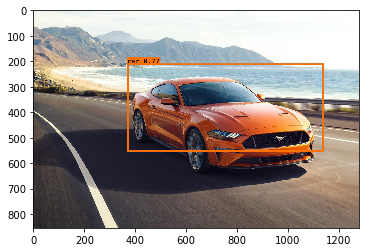

In [23]:
out_scores, out_boxes, out_classes = predict(sess, "tt.jpeg")

Found 2 boxes for 0011.jpg
truck 0.73 (727, 269) (1054, 376)
car 0.85 (6, 336) (212, 457)
Found 2 boxes for 0012.jpg
car 0.77 (792, 279) (1163, 408)
car 0.87 (539, 330) (998, 459)
Found 1 boxes for 0013.jpg
truck 0.65 (718, 276) (1053, 385)
Found 1 boxes for 0014.jpg
truck 0.64 (715, 274) (1056, 385)
Found 1 boxes for 0015.jpg
truck 0.72 (713, 275) (1086, 386)
Found 1 boxes for 0016.jpg
truck 0.63 (708, 276) (1106, 388)
Found 3 boxes for 0017.jpg
truck 0.64 (666, 274) (1063, 392)
car 0.79 (1103, 300) (1271, 356)
car 0.82 (1, 358) (183, 427)
Found 2 boxes for 0018.jpg
car 0.76 (71, 362) (242, 419)
car 0.77 (340, 339) (553, 401)
Found 2 boxes for 0019.jpg
truck 0.64 (685, 275) (1050, 396)
car 0.85 (16, 377) (450, 559)
Found 1 boxes for 0020.jpg
truck 0.75 (538, 286) (926, 413)
Found 2 boxes for 0021.jpg
car 0.62 (691, 292) (914, 403)
truck 0.72 (88, 317) (493, 450)
Found 2 boxes for 0022.jpg
car 0.65 (894, 302) (980, 348)
car 0.79 (751, 318) (879, 370)
Found 0 boxes for 0023.jpg
Found 0 

FileNotFoundError: [Errno 2] No such file or directory: 'images/00100.jpg'

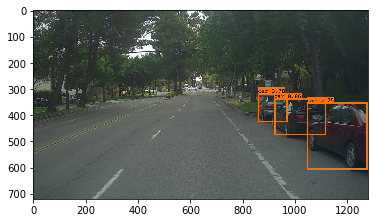

In [25]:
for i in range(11,121):
    out_scores, out_boxes, out_classes = predict(sess, "00"+str(i)+".jpg")

**Expected Output**:

<table>
    <tr>
        <td>
            **Found 7 boxes for test.jpg**
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.60 (925, 285) (1045, 374)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.66 (706, 279) (786, 350)
        </td>
    </tr>
    <tr>
        <td>
            **bus**
        </td>
        <td>
           0.67 (5, 266) (220, 407)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.70 (947, 324) (1280, 705)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.74 (159, 303) (346, 440)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.80 (761, 282) (942, 412)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.89 (367, 300) (745, 648)
        </td>
    </tr>
</table>

**References**: The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's github repository. The pretrained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 

**Car detection dataset**:
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The Drive.ai Sample Dataset</span> (provided by drive.ai) is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. We are especially grateful to Brody Huval, Chih Hu and Rahul Patel for collecting and providing this dataset. 